# TP4

In [2]:
from qiskit import *
import qiskit.visualization as viz
import numpy as np
from random import randint # pour la question 2

# for imbq API access
import os
import json

### 1 - Etude mathématique

Énoncé du problème :
Soient trois portes, l'une cache une voiture, les deux autres une chèvre. Les prix sont répartis par tirage au sort.
Le présentateur connaît la répartition des prix.
Le joueur choisit une des portes, mais rien n'est révélé.
Le présentateur ouvre une autre porte ne révélant pas la voiture.
Le présentateur propose au candidat de changer son choix de porte à ouvrir définitivement.
Le joueur a-t-il plus de chance d'obtenir la voiture en changeant systématiquement son choix de base ?

Cas possibles:
On définit les évènements :
(C1) : le candidat a choisi la porte de la chèvre 1
(C2) : le candidat a choisi la porte de la chèvre 2
(V) : le candidat a choisi la porte de la voiture
qui définissent l'ensemble des évènements de départ possibles, avec P(C1) = P(C2) = P(V)

Quel est la suite des évènements pour chacune des situation de départ ?
Première situation (C1) : Le candidat ayant initialement choisi la porte de la chèvre 1, le présentateur ouvre la porte de la chèvre 2. La porte restante cache la voiture.
Deuxième situation (C2) : Le candidat ayant initialement choisi la porte de la chèvre 2, le présentateur ouvre la porte de la chèvre 1. La porte restante cache la voiture.
Dernière situation (V) : Le candidat ayant initialement choisi la porte de la voiture, le présentateur ouvre la porte d'une des deux chèvres. La porte restante cache une chèvre.

Au niveau des probabilités :

On note
C : le joueur a choisi initialement une des deux portes contenant une chèvre, et P(C) = 2/3.
GVC : le joueur gagne la voiture sans changer de porte
GVS : le joueur gagne la voiture en changeant de porte

On a vu précédemment que $P(GVC \mid C)$ = 1, et $P(GVC \mid V)$ = 0
D'où P(GVC) = $P(GVC \mid C)$ * P(C) + $P(GVC \mid V)$ * P(V) = 2/3

De plus,
$P(GVS \mid V)$ = 1 et $P(GVS \mid C)$ = 0
D'où P(GVS) = $P(GVS \mid V)$ * P(V) + $P(GVS \mid C)$ * P(C) = 1/3

On en déduit que le joueur a en effet plus de chances de gagner en changeant systématiquement son choix de porte

### 2 - Implémentation classique du jeu

In [12]:
def play_game(n_doors = 3, change_door_after_reveal=False):
    choice = randint(1, n_doors) # effectue le choix initial du joueur
    winning_door = randint(1, n_doors) # determine la porte gagnante
    if change_door_after_reveal: # reveals another door that is neither the right one nor the chosen one
        new_choice = 1
        while new_choice != choice and new_choice != winning_door:
            new_choice += 1
        choice = new_choice
    return choice == winning_door


# calculates the probability of winning

print("Keep first choice", np.mean([play_game(3, False) for _ in range(1000)]))

print("Change door after reveal", np.mean([play_game(3, True) for _ in range(1000)]))

Keep first choice 0.331
Change door after reveal 0.695


Nous avons donc obtenu **les taux de victoire pour chaque stratégie**.

On remarque que la fonction play_game nécessite un nombre conséquent d'itérations pour converger manifestement vers la probabilité réelle de gagner dans chaque situation.

On espère réduire drastiquement cette complexité en utilisant le circuit quantique.

### 3.1 - Analyse du schéma du circuit

In [4]:
class CustomCircuit():
    def __init__(self, circuit):
        self.circuit = circuit # wrapper sur Qiskit::QuantumCircuit

    def __call__(self):
        return self.circuit

    def run(self, backend_id='qasm_simulator', shots='1024'):
        """
        runs the circuit on a simulator and returns a standard result object
        """
        simulator = Aer.get_backend(backend_id)
        job = execute(self.circuit, simulator, shots=shots)

        # Get the results
        return job.result()
    
    def run_ibmq(self, backend_id='ibm_brisbane'):
        """
        runs the circuit on an actual quantum computer and returns a standard result object
        """
        # IMPORT DE TOKEN IMBQ
        assert os.path.exists('tokens.json') # SINON DEFINIR SON TOKEN DIRECTEMENT
        # token = "..."

        with open('tokens.json', 'r') as f:
            token = json.load(f)['ibmq']

        IBMQ.save_account(token)
        provider = IBMQ.load_account()

        backend = provider.get_backend(backend_id) # pour determiner id >> la 2e cellule du notebook

        optimized_circuit = transpile(self.circuit, backend)
        job = backend.run(optimized_circuit) # suivi d'usage : https://quantum-computing.ibm.com/
        retrieved_job = backend.retrieve_job(job.job_id())
        return retrieved_job.result()


    def counts(self, *args, **kwargs):
        result = self.run(*args, **kwargs)
        return result.get_counts()

    def draw(self):
        """
        pretty graphing method
        """
        return self.circuit.draw(output='mpl')
    
    def vizcounts(self):
        return viz.plot_histogram(self.counts())
    
    def vizbloch(self):
        """
        returns a bloch sphere representation of the circuit
        """
        statevector = self.run(backend_id='statevector_simulator').get_statevector()
        return viz.plot_bloch_multivector(statevector)

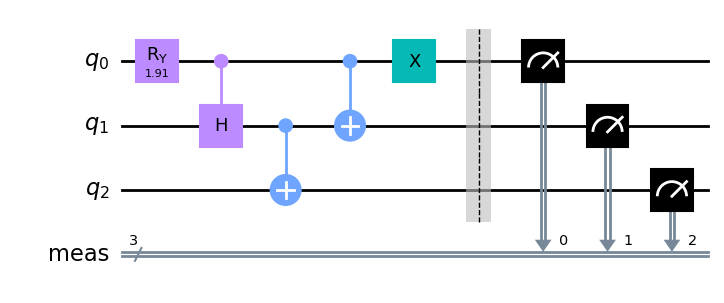

In [10]:
# se concentrer sur le choix de la porte numéro 2
# avec un qubit on peut se concentrer sur 2 valeurs : 
# est ce qu'il va choisir de révéler zero, ou de révéler le 1

qc = CustomCircuit(QuantumCircuit(3))

qc.circuit.ry(1.91, 0)
qc.circuit.ch(0, 1)
qc.circuit.cx(1, 2)
qc.circuit.cx(0, 1)
qc.circuit.x(0)

qc.circuit.measure_all()

qc.draw()

à psi 0 on tous les qubits sont initialisés à |0>, on a un état |000>

à psi 1 on a effectué une rotation sur le qubit 0, de manière à obtenir 1 chance sur 3 d'avoir le qubit 0 à 0 et 1 chance sur 3 de l'avoir à 1, l'état est donc : sqrt(1/3) |000> + sqrt(2/3) |100>

à psi 2 on a appliqué une porte hadamard conditionnelle sur le premier qubit, qui est placé en superposition |+> (1 chance sur 2 de mesurer 1) sur la probabilité que q0 serait mesuré à 1 (connu par la rotation), sinon q1 reste |0>, on obtenient donc : sqrt(1/3) |000> + sqrt(2/3 * 1/2) |100> + sqrt(2/3 * 1/2) |110>

à psi 3 on applique un conditional not entre q1 et q2 ce qui contraint l'état mesuré à être le même que q1, soit : sqrt(1/3) |000> + sqrt(1/3) |100> + sqrt(1/3) |111>

à psi 4 on applique un cnot entre q0 et q1, ce qui inverse la valeur de q1 pour les états où q0 était 1 : sqrt(1/3) |000> + sqrt(1/3) |110> + sqrt(1/3) |101>

à psi 5 on a appliqué un not sur q0 : sqrt(1/3) |100> + sqrt(1/3) |010> + sqrt(1/3) |001>

**C'est donc ainsi qu'on se retrouve avec seulement 3 états possibles et équiprobables.**

#### (voir conclusion ci dessous qui répond à la question)

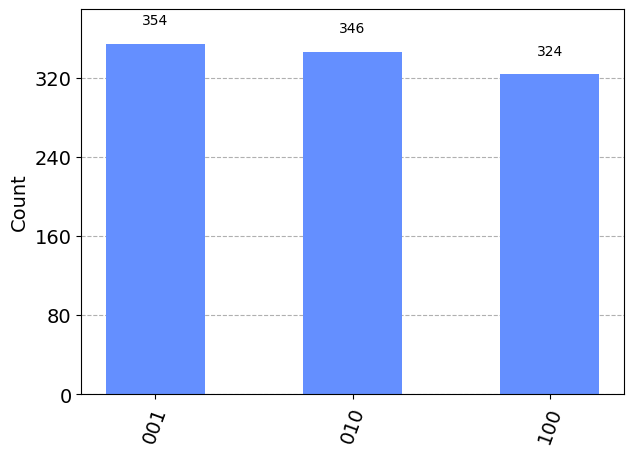

In [11]:
qc.vizcounts()

Conclusion : on constate bien que les qubits de ce circuit sont intriqués de telle manière que lorsqu'un d'entre deux est mesuré avec une valeur de 1, les deux autres doivent nécessairement être 0.

Cela nous permet de représenter **au travers des états de ce circuit** les trois configurations qui représentent derrière quelle porte se trouverait la voiture, que nous pouvons également assimiler aux différents événement de la première stratégie, où on ne change pas de porte après en avoir choisi une.

On constate dans cette configuration que la probabilité d'obtenir chacune des configurations est bien équiprobable, ce qui montre que la situation est correctement modélisée.

Dans la partie suivante, nous allons ajouter des contraintes qui représentent l'événement du changement de porte.

### 3.2 - Décision de Monty

c:\Users\ongki\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


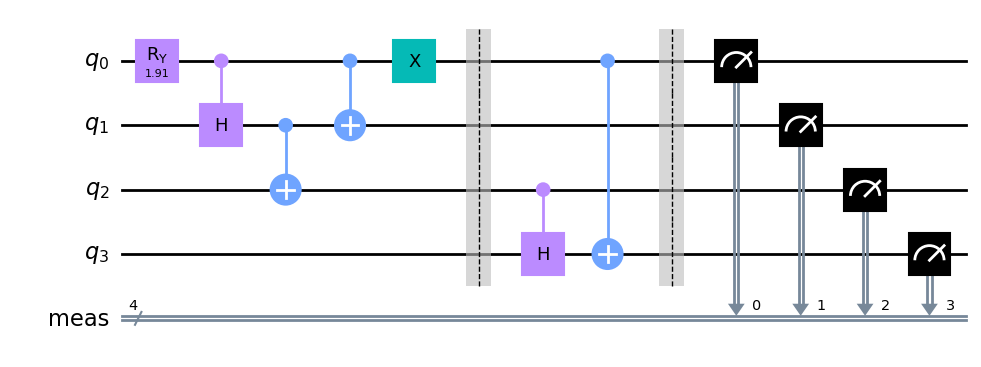

In [7]:
# se concentrer sur le choix de la porte numéro 2
# avec un qubit on peut se concentrer sur 2 valeurs : 
# est ce qu'il va choisir de révéler zero, ou de révéler le 1

qc = CustomCircuit(QuantumCircuit(4))
qc.circuit.ry(1.91, 0)
qc.circuit.ch(0, 1)
qc.circuit.cx(1, 2)
qc.circuit.cx(0, 1)
qc.circuit.x(0)

# q0 = 1 => q3 = 1 && q1 = 1 => q3 = 0
qc.circuit.barrier()
qc.circuit.ch(2, 3)
qc.circuit.cx(0, 3) # q0 contient "not q0" à ce stade


# qc.circuit.x(3) # pour tester l'ordre dans lequel sont mesurés les qbits

qc.circuit.measure_all()

qc.draw()

### Circuit complété avec q3 et les portes nécessaires

{'1001': 340, '0010': 335, '1100': 188, '0100': 161}


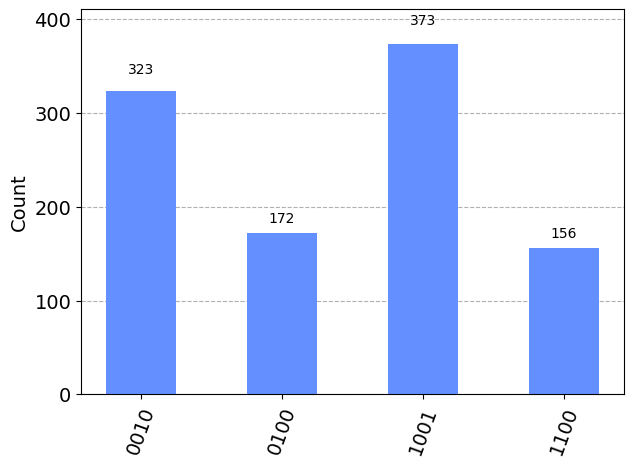

In [8]:
print(qc.counts())
qc.vizcounts() # !!! à cause de la méthode .measure_all(),
# les qbits sont mesurés comme : [q3 q2 q1 q0] (le bit le plus à gauche est q3)

### Identification des solutions

Si la voiture ne se trouve pas derrière la porte 2 (celle que j'ai choisi initialement), Monty me montre nécessairement une mauvaise porte, ce qui me permet d'identifier la porte derrière laquelle se trouve la voiture et de remporter le prix.

Les situations **gagnantes** avec la méthode 2 sont donc les suivantes : 

1001 correspond à la situation : "la voiture est derrière la porte q0, Monty me montre q1, je choisi donc q0"

0010 correspond à la situation : "la voiture est derrière la porte q1, Monty me montre q0, je choisi donc q1"

Les situations **perdantes** sont celles où la voiture se trouve derrière la porte que j'ai choisi initialement : 

0100 "la voiture est derrière la porte q2, Monty me montre q0, je choisi donc q1"

1100 "la voiture est derrière la porte q2, Monty me montre q1, je choisi donc q0"

In [9]:
winning = ('0010', '1001')
losing = ('0100', '1100')

results = qc.counts(shots='10000')
total = np.sum([results[w] for w in winning + losing])
print('proportion of winning situations :', np.sum([results[w] for w in winning]) / total)
print('proportion of losing situations :', np.sum([results[w] for w in losing]) / total)

proportion of winning situations : 0.6645
proportion of losing situations : 0.3355


**On calcule la probabilité d'observer un état gagnant ou perdant en faisant le rapport entre la somme des observations pour chaque catégorie (gagnant ou perdant) et le nombre d'observations**

Par symétrie, on réalise qu'on peut modéliser la même situation et obtenir le même résultat peu importe la porte choisie initialement. (ici c'était la porte numéro 2)

Ces stratégies (choisir une porte et changer de porte après l'action de Monty) conduisent à une situation de victoire 2/3 du temps, comme indiqué par les résultats du système quantique qui modélise la situation.

Dans le circuit qui modélise la situation où on conserve son choix initial, la probabilité d'être dans une situation gagnante (la voiture est sur la porte choisie) est de seulement 1/3 puisque la voiture a 1 chance sur 3 d'être derrière une porte particulière.

**La stratégie de changer de porte est donc la meilleure.**

L'information de ce résultat est contenu dans la configuration d'un seul qubit, il faut cependant effectuer plusieurs mesures pour parvenir à le retrouver si on n'utilise que les bases |0> |1>